## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import matplotlib.pyplot as plt
import os

np.random.seed(42)

## Some Utility Functions

In [11]:
def set_day(df):
    '''
    This function assigns day names to each of the rows in the dataset.
    '''
    ## Assumes the first day-of the dataset is Saturday
    days = ["Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"]
    temp = ['d']*df.shape[0]
    i = 0
    indx = 0
    cur_day=df.weekday[0]
    for day in df.weekday:
        temp[indx] = days[(day-cur_day+7)%7]
        indx += 1
    df['dayWeek'] = temp
    return df

def mnth_cnt(df):
    '''
    Compute the count of months from the start of the 
    time series.
    '''
    import itertools
    yr = df['yr'].tolist()
    mnth = df['mnth'].tolist()
    out = [0] * df.shape[0]
    indx = 0
    for x,y in zip(mnth, yr):
        out[indx] = x + 12 * y
        indx += 1
    return out

def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard Deviation: {scores.std()}')

## Loading the data

In [12]:
filePath = os.path.join("datasets")
bikesData = pd.read_csv(os.path.join(filePath, "bikes.csv"))
bikesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [13]:
len(bikesData)

17379

## Data cleaning

In [16]:
# Update the columnsToDrop variable in the order given
columnsToDrop = ['instant', 'casual', 'registered', 'atemp', 'dteday']
bikesData.drop(columnsToDrop, 1, inplace=True)
bikesData.head()

/var/folders/z5/4mx8mg_x50z2k87t73ygjg8m0000gn/T/ipykernel_51878/1538716014.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  bikesData.drop(columnsToDrop, 1, inplace=True)


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1


In [17]:
# Update the columnsToScale variable in the order given
columnsToScale = ['temp', 'hum', 'windspeed']

scaler = StandardScaler()

bikesData[columnsToScale] = scaler.fit_transform(bikesData[columnsToScale])
bikesData[columnsToScale].describe()

,temp,hum,windspeed
count,1.737900e+04,1.737900e+04,1.737900e+04
mean,3.497212e-16,-4.195150e-16,4.038186e-15
std,1.000029e+00,1.000029e+00,1.000029e+00
min,-2.477205e+00,-3.251166e+00,-1.553889e+00
25%,-8.153035e-01,-7.631431e-01,-6.996886e-01
50%,1.564696e-02,1.436398e-02,3.189880e-02
75%,8.465975e-01,7.918711e-01,5.198962e-01
max,2.612367e+00,1.932215e+00,5.399871e+00


In [18]:
bikesData.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,-1.334648,0.947372,-1.553889,16
1,1,0,1,1,0,6,0,1,-1.438516,0.895539,-1.553889,40
2,1,0,1,2,0,6,0,1,-1.438516,0.895539,-1.553889,32
3,1,0,1,3,0,6,0,1,-1.334648,0.636370,-1.553889,13
4,1,0,1,4,0,6,0,1,-1.334648,0.636370,-1.553889,1


## Adding derived features and transforming the data

In [19]:
bikesData['isWorking'] = np.where(np.logical_and(bikesData.workingday==1,bikesData.holiday==0),1,0)
bikesData['monthCount'] = mnth_cnt(bikesData)
bikesData['xformHr'] = np.where(bikesData.hr>4,bikesData.hr-5,bikesData.hr+19)
bikesData['dayCount'] = pd.Series(range(bikesData.shape[0]))/24
bikesData['xformWorkHr'] = (1-bikesData.isWorking)*24 + bikesData.xformHr
bikesData = set_day(bikesData)

In [20]:
np.where(np.logical_and(bikesData.workingday==1,bikesData.holiday==0),1,0)

array([0, 0, 0, ..., 1, 1, 1])

In [26]:
bikesData.sort_values('dayCount', axis= 0, inplace=True)
nrow = bikesData.shape[0]
X = bikesData.dayCount.values.reshape(nrow,1)
Y = bikesData.cnt
clf = linear_model.LinearRegression()
bike_lm = clf.fit(X, Y)

# Task
bikesData['cntDeTrended'] = bikesData.cnt - bike_lm.predict(X)

## Analyzing and visualizing the dataset

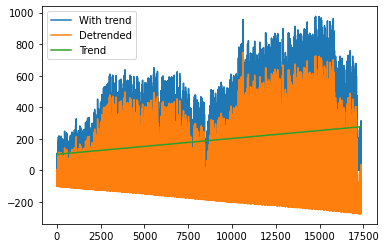

In [27]:
plt.plot(bikesData.loc[:,'cnt'])
plt.plot(bikesData.loc[:,'cntDeTrended'])
plt.plot(bike_lm.predict(X))
plt.legend(['With trend','Detrended','Trend'])
plt.show()

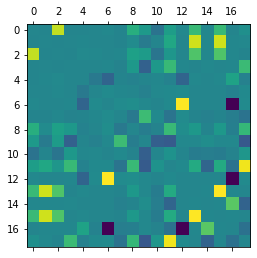

In [32]:
corrMat = bikesData.corr().values
np.fill_diagonal(corrMat, 0)
plt.matshow(corrMat)
#plt.xlabel(bikesData.columns.values)
plt.show()

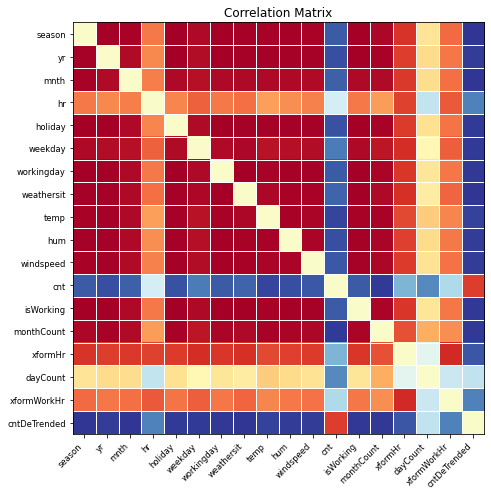

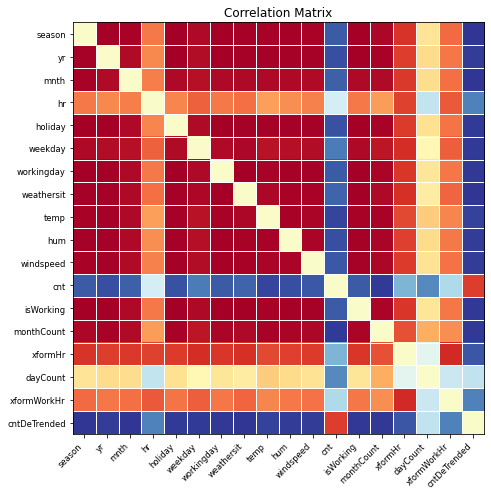

In [35]:
import statsmodels.graphics.correlation as pltcor
arr = bikesData.drop('dayWeek', axis = 1)
cols = list(arr)
arr = arr.values
arr = preprocessing.scale(arr, axis = 1)
corrMat = np.corrcoef(arr, rowvar =0)
np.fill_diagonal(corrMat, 0)
fig = plt.figure(figsize=(7,7))
ax = fig.gca()
pltcor.plot_corr(corrMat, xnames = cols, ax=ax)

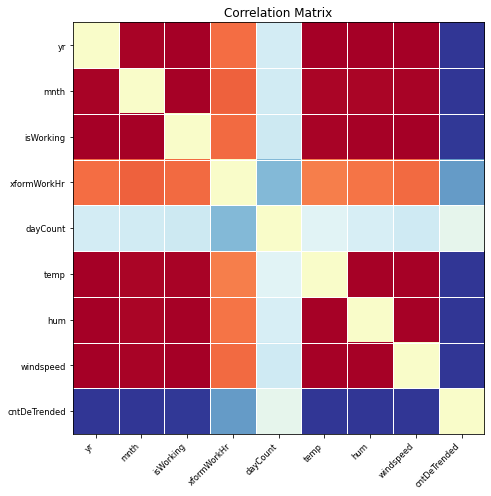

In [41]:
columnToPlotScatter = ['yr','mnth','isWorking','xformWorkHr','dayCount','temp','hum','windspeed','cntDeTrended']

arry = bikesData[columnToPlotScatter].values
arry = preprocessing.scale(arry, axis = 1)
corrs = np.corrcoef(arry, rowvar = 0)
np.fill_diagonal(corrs, 0)
col_nms = list(bikesData)[1:]
fig = plt.figure(figsize = (7,7))
ax = fig.gca()
pltcor.plot_corr(corrs, xnames = columnToPlotScatter, ax = ax)
plt.show()

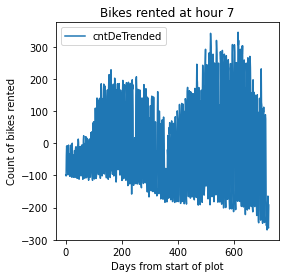

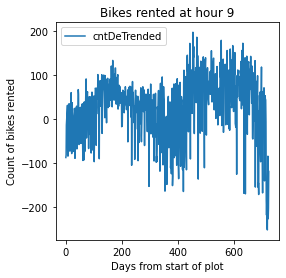

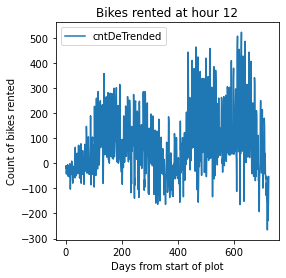

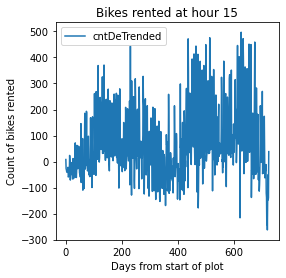

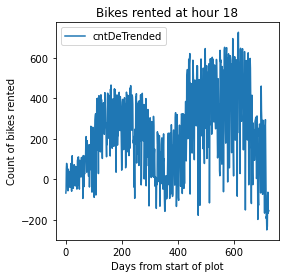

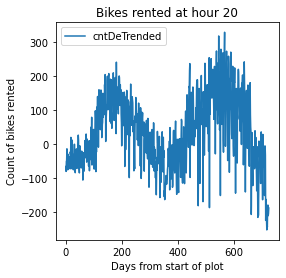

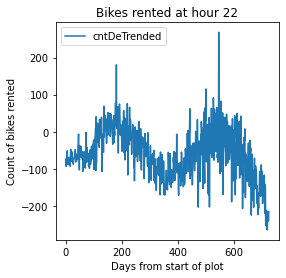

In [42]:
times = [7, 9, 12, 15, 18, 20, 22]
for time in times:
    fig = plt.figure(figsize=(4,4))
    tsToPlot = bikesData[bikesData.hr==time]
    fig.clf()
    ax = fig.gca()
    tsToPlot.plot(kind='line', x='dayCount', y='cntDeTrended', ax =ax)
    plt.xlabel("Days from start of plot")
    plt.ylabel("Count of bikes rented")
    plt.title("Bikes rented at hour " + str(time))
    plt.show()

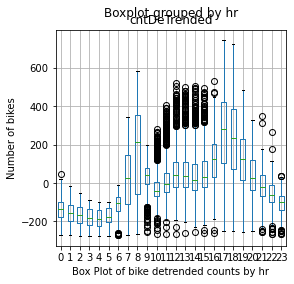

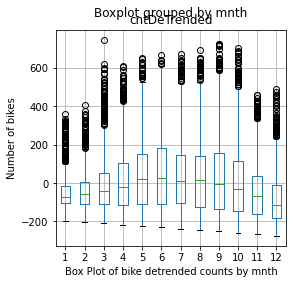

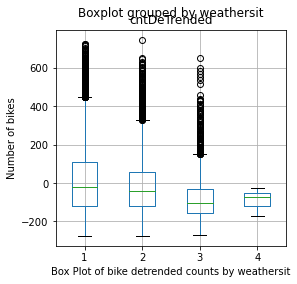

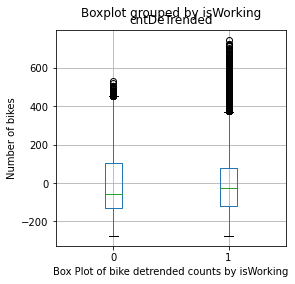

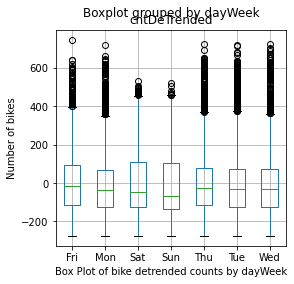

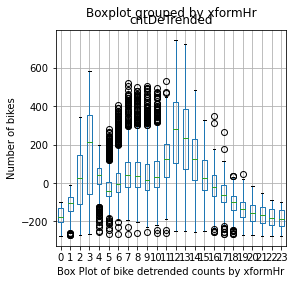

In [43]:
colstoBoxPlot = ['hr','mnth','weathersit','isWorking','dayWeek','xformHr']

for cols in colstoBoxPlot:
    fig = plt.figure(figsize=(4,4))
    fig.clf()
    ax = fig.gca()
    bikesData.boxplot(column=['cntDeTrended'], by = [cols], ax = ax)
    plt.xlabel('Box Plot of bike detrended counts by '+str(cols))
    plt.ylabel('Number of bikes')
    plt.show()

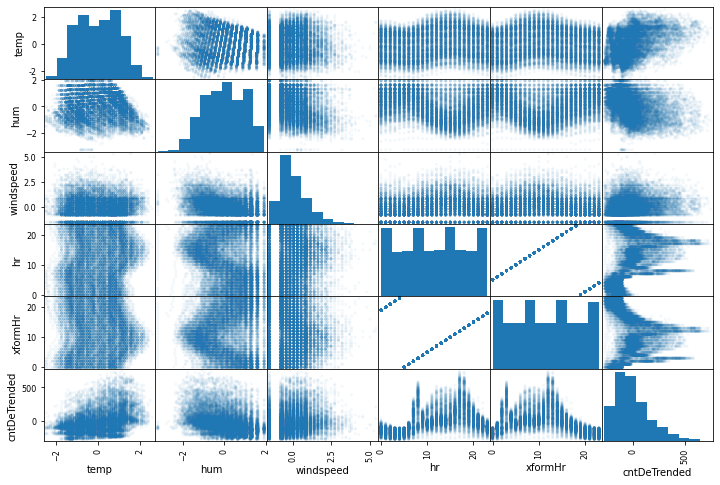

In [44]:
columnToPlotScatter = ['temp','hum','windspeed','hr','xformHr','cntDeTrended']
from pandas.plotting import scatter_matrix
scatter_matrix(bikesData[columnToPlotScatter], figsize=(12,8), alpha=0.05)
plt.show()

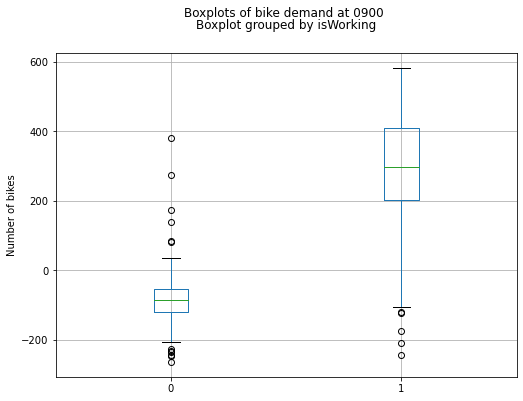

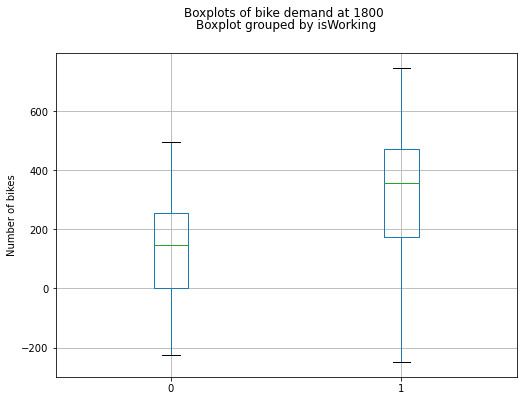

In [45]:
labels = ["Boxplots of bike demand at 0900 \n\n", "Boxplots of bike demand at 1800 \n\n"]
times = [8, 17]
# Task: Complete these statements
col = ['cntDeTrended']
byCol = ['isWorking']
for lab, tms in zip(labels, times):
    temp = bikesData[bikesData.hr == tms]
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()
    
    temp.boxplot(column = col, by = byCol, ax = ax)
    plt.xlabel('')
    plt.ylabel('Number of bikes')
    plt.title(lab)
    plt.show()

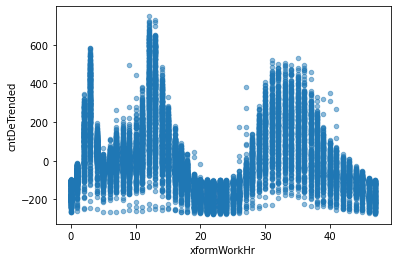

In [46]:
x_plot = 'xformWorkHr'
y_plot = 'cntDeTrended'
ax = fig.gca()
bikesData.plot(kind='scatter', x = x_plot, y = y_plot, alpha = 0.5)
plt.show()

## Dividing the dataset to training and testing datasets

In [47]:
from sklearn.model_selection import train_test_split
# Task: Correct the train_test_split function to split the test set in the ratio 70:30
train_set, test_set = train_test_split(bikesData, test_size=0.3, random_state=42)
train_set.sort_values('dayCount', axis= 0, inplace=True)
test_set.sort_values('dayCount', axis= 0, inplace=True)
print(len(train_set), "train +", len(test_set), "test")

12165 train + 5214 test


/Users/nipunaupeksha/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


## Training and analyzing

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [49]:
trainingCols = train_set[['xformWorkHr','temp','dayCount']]
trainingLabels = train_set['cnt']

# Train a Decision Tree Regressor
rfc_clf = DecisionTreeRegressor(random_state = 42)
display_scores(-cross_val_score(rfc_clf, trainingCols, trainingLabels, cv=10, scoring="neg_mean_absolute_error"))
display_scores(np.sqrt(-cross_val_score(rfc_clf, trainingCols, trainingLabels, cv=10, scoring="neg_mean_squared_error")))
train_set_dtr = train_set.copy()
train_set_dtr['predictedCounts'] = cross_val_predict(rfc_clf, trainingCols, trainingLabels, cv=10)
train_set_dtr['resids'] = train_set_dtr['predictedCounts'] - trainingLabels

Scores: [ 29.37222679  48.46507806  37.08874281  54.01643385  54.47411668
  57.77138158  64.79029605  63.81414474  55.57401316 100.21052632]
Mean: 56.557696003438124
Standard Deviation: 17.952218990725587
Scores: [ 45.95970154  74.51177712  58.77977925  88.94009321  87.18584406
  90.6675626  106.76725101 100.5444717   92.66354674 154.47246284]
Mean: 90.04924900874488
Standard Deviation: 27.784382154078404


In [50]:
# Train a Linear Regression model
lin_reg = LinearRegression()
display_scores(-cross_val_score(lin_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_absolute_error"))
display_scores(np.sqrt(-cross_val_score(lin_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_squared_error")))
train_set_lin = train_set.copy()
train_set_lin['predictedCounts'] = cross_val_predict(rfc_clf, trainingCols, trainingLabels, cv=10)
train_set_lin['resids'] = train_set_lin['predictedCounts'] - trainingLabels

Scores: [ 62.29527472  90.60871832 134.99710104 120.7050177   87.65203691
  95.09526459 153.68788949 177.0099255  183.21306065 137.61263548]
Mean: 124.2876924419533
Standard Deviation: 38.20076938330597
Scores: [ 79.02462583 119.71270616 154.46146441 143.1340909  110.38911514
 129.89481215 198.27301911 210.5833168  229.90475061 176.62358571]
Mean: 155.20014868275683
Standard Deviation: 45.62773468813647


In [51]:
# Let's train one more model using Random Forests
# Task 1: make changes here
forest_reg = RandomForestRegressor(n_estimators=40, random_state=42)

# Task 2: Is everything ok here?
display_scores(-cross_val_score(forest_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_absolute_error"))
display_scores(np.sqrt(-cross_val_score(forest_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_squared_error")))
train_set_freg = train_set.copy()
train_set_freg['predictedCounts'] = cross_val_predict(forest_reg, train_set[['xformWorkHr','temp','dayCount']], trainingLabels, cv=10)
train_set_freg['resids'] = train_set_freg['predictedCounts'] - trainingLabels

Scores: [26.07551356 37.45792933 32.1267461  43.11828266 43.25595727 48.12541118
 55.84251645 52.82652138 47.65933388 73.29340049]
Mean: 45.97816123117404
Standard Deviation: 12.545619145343972
Scores: [ 41.3152194   58.94087734  49.70129401  69.91267933  70.63000993
  76.74023564  90.24194458  80.83799636  80.11283276 112.17584682]
Mean: 73.06089361900376
Standard Deviation: 19.281008377259905


## Visualizing predication vs. actual data

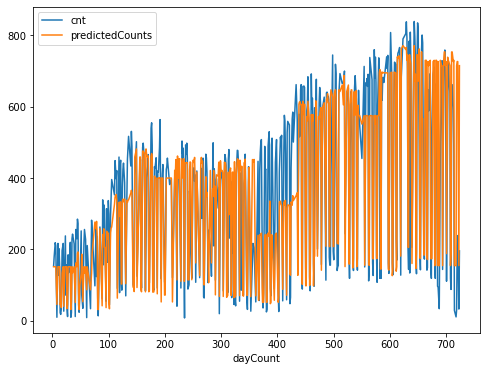

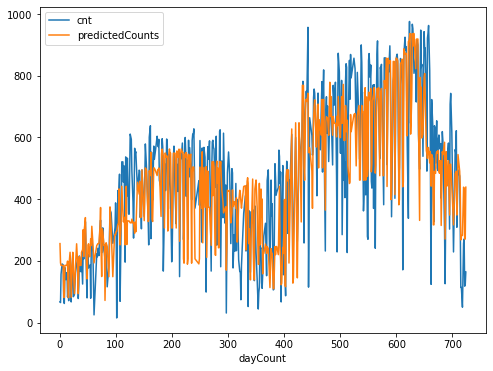

In [52]:
# Just to plot, try to add more details to the plots

times = [8,17]
for time in times:
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()
    train_set_freg_time = train_set_freg[train_set.hr == time]
    train_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'cnt', ax = ax)
    train_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'predictedCounts', ax =ax)
    plt.show()

## Fine tuning model

**Task 1**: Assign different combination of max_dept and min_samples_leaf and min_samples_split to param_grid - 'max_depth': [28, 30, 32, 34, 36], 'min_samples_leaf': [5, 10, 15, 12],'min_samples_split': [120, 128, 136]

**Task 2**: Calculate the best parameter using GridSearchCV and store it in grid_search. Print the parameters. from sklearn.model_selection import GridSearchCV

**Task 3**: Fit the training dataset to the calculated best parameter model using the fit() method.

**Task 4**: Complete the code to calculate the importance score for each of the feature

In [53]:
from sklearn.model_selection import GridSearchCV

# Task 1
param_grid = [
    {'max_depth': [28, 30, 32, 34, 36], 'min_samples_leaf': [5, 10, 15, 12],'min_samples_split': [120, 128, 136]},
]

# Task 2
grid_search = GridSearchCV(rfc_clf, param_grid, cv=5, scoring='neg_mean_squared_error')

# Task 3
grid_search.fit(trainingCols, trainingLabels)
print(grid_search.best_params_)

# See the importance score of each attribute in GridSearchCV
# Task 4
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

{'max_depth': 28, 'min_samples_leaf': 12, 'min_samples_split': 120}
[0.71508045 0.11661388 0.16830567]


In [55]:
feature_importances

array([0.71508045, 0.11661388, 0.16830567])

## Extract the model on test data

In [56]:
final_model = grid_search.best_estimator_

test_set.sort_values('dayCount', axis= 0, inplace=True)

# Task 1: Complete the statement below to extract relevant columns from the test dataset
test_x_cols = ['xformWorkHr', 'temp','dayCount']

# Task 2: Complete the statement below to extract relevant label from test set
test_y_cols = 'cnt'

X_test = test_set.loc[:,test_x_cols]
y_test = test_set.loc[:,test_y_cols]

# Task 3: Calculate the predicted values from the model and store it in 'predictedCounts_test'
test_set.loc[:,'predictedCounts_test'] = final_model.predict(X_test)

# Task 4: Calculate the mean squared error using mean_squared_error function.
final_mse = mean_squared_error(y_test, test_set.loc[:,'predictedCounts_test'])
print(np.sqrt(final_mse))
test_set.describe()

62.18673266056164


/Users/nipunaupeksha/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/nipunaupeksha/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,isWorking,monthCount,xformHr,dayCount,xformWorkHr,cntDeTrended,predictedCounts_test
count,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000
mean,2.481204,0.504411,6.480437,11.471423,0.030687,3.001534,0.685846,1.422133,-0.012980,-0.002944,0.012217,185.322785,0.685846,12.533372,11.415036,360.850898,18.954737,-3.852672,186.253915
std,1.110062,0.500028,3.457991,6.887845,0.172484,1.995486,0.464223,0.637995,0.993567,0.995428,1.006002,177.755171,0.464223,6.843005,6.909181,207.769276,13.057057,171.964728,167.254476
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.477205,-3.251166,-1.553889,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-274.491766,2.168831
25%,1.000000,0.000000,3.000000,6.000000,0.000000,1.000000,0.000000,1.000000,-0.815304,-0.763143,-0.699689,41.000000,0.000000,7.000000,5.000000,180.781250,8.000000,-124.743847,50.210526
50%,2.000000,1.000000,6.000000,11.000000,0.000000,3.000000,1.000000,1.000000,0.015647,0.014364,0.031899,136.000000,1.000000,13.000000,11.000000,362.375000,17.000000,-37.980680,142.560345
75%,3.000000,1.000000,9.000000,17.000000,0.000000,5.000000,1.000000,2.000000,0.742729,0.791871,0.519896,277.000000,1.000000,18.000000,17.000000,537.104167,28.000000,81.281369,277.350515
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,2.404630,1.932215,5.399871,977.000000,1.000000,24.000000,23.000000,724.041667,47.000000,726.303828,832.485294


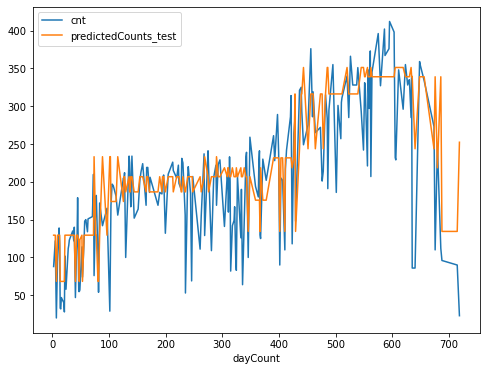

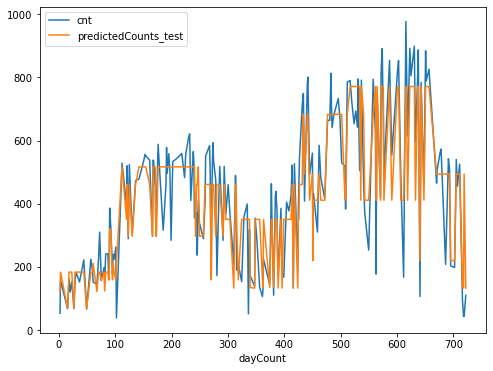

In [57]:
times = [9,18]
for time in times:
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()
    test_set_freg_time = test_set[test_set.hr == time]
    test_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'cnt', ax = ax)
    test_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'predictedCounts_test', ax =ax)
    plt.show()

## Analyzing the residuals

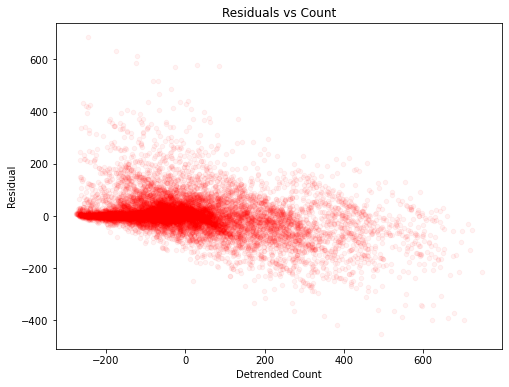

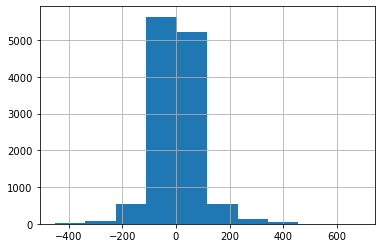

In [58]:
import statsmodels.api as sm

## Plot the residuals vs the label, the count of rented bikes.
fig = plt.figure(figsize=(8, 6))
fig.clf()
ax = fig.gca()
train_set_freg.plot(kind = 'scatter', x = 'cntDeTrended', y = 'resids', alpha = 0.05, color = 'red', ax = ax)
plt.xlabel("Detrended Count")
plt.ylabel("Residual")
plt.title("Residuals vs Count")
plt.show()
## Plotting the resilduals
train_set_freg['resids'].hist()
plt.show()

In [59]:
train_set_freg.boxplot(column = ['resids'], by = ['hr'], ax = ax)
plt.show()

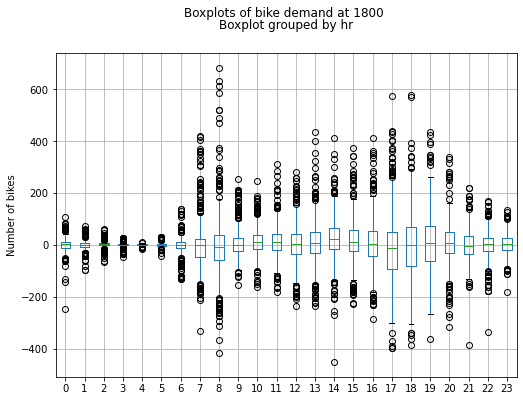

In [60]:
fig = plt.figure(figsize=(8, 6))
fig.clf()
ax = fig.gca()
train_set_freg.boxplot(column = ['resids'], by = ['hr'], ax = ax)
plt.xlabel('')
plt.ylabel('Number of bikes')
plt.title(lab)
plt.show()

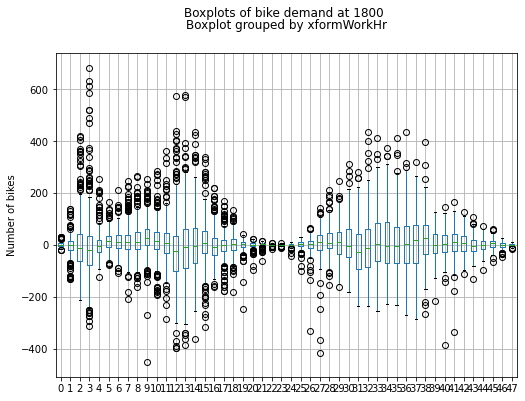

In [61]:
fig = plt.figure(figsize=(8, 6))
fig.clf()
ax = fig.gca()
train_set_freg.boxplot(column = ['resids'], by = ['xformWorkHr'], ax = ax)
plt.xlabel('')
plt.ylabel('Number of bikes')
plt.title(lab)
plt.show()

## Building a transformation pipeline

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [65]:
filePath = os.path.join("datasets","bikes.csv")

## Task: Complete the statement below
bikesData = pd.read_csv(filePath)

print(bikesData.info())

columnsToDrop = ['instant','casual','registered','atemp','dteday']
bikesData = bikesData.drop(columnsToDrop,1)

bikesData['isWorking'] = np.where(np.logical_and(bikesData.workingday==1,bikesData.holiday==0),1,0)
bikesData['monthCount'] = mnth_cnt(bikesData)
bikesData['xformHr'] = np.where(bikesData.hr>4,bikesData.hr-5,bikesData.hr+19)
bikesData['dayCount'] = pd.Series(range(bikesData.shape[0]))/24
bikesData['xformWorkHr'] = bikesData.isWorking*24 + bikesData.xformHr
bikesData = set_day(bikesData)
bikesData.describe()

columnsToScale = ['temp','hum','windspeed']
scaler = StandardScaler()
bikesData[columnsToScale] = scaler.fit_transform(bikesData[columnsToScale])
arry = bikesData[columnsToScale].values
bikesData[columnsToScale] = preprocessing.scale(arry)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None


/var/folders/z5/4mx8mg_x50z2k87t73ygjg8m0000gn/T/ipykernel_51878/1061532588.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  bikesData = bikesData.drop(columnsToDrop,1)


In [66]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        isWorking = np.where(np.logical_and(X.loc[:,'workingday']==1,X.loc[:,'holiday']==0),1,0)
        xformHr = np.where(X.loc[:,'hr']>4,X.loc[:,'hr']-5,X.loc[:,'hr']+19)
        xformWorkHr = isWorking*24 + xformHr
        return np.c_[X, isWorking, xformHr, xformWorkHr]

In [67]:
attr_adder = CombinedAttributesAdder()
bikesData1 = attr_adder.transform(bikesData)
bikesData = pd.DataFrame(bikesData1, columns=list(bikesData.columns)+["isWorking", "xformHr", "xformWorkHr"])
bikesData.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,...,cnt,isWorking,monthCount,xformHr,dayCount,xformWorkHr,dayWeek,isWorking,xformHr,xformWorkHr
0,1,0,1,0,0,6,0,1,-1.334648,0.947372,...,16,0,1,19,0.0,19,Sat,0,19,19
1,1,0,1,1,0,6,0,1,-1.438516,0.895539,...,40,0,1,20,0.041667,20,Sat,0,20,20
2,1,0,1,2,0,6,0,1,-1.438516,0.895539,...,32,0,1,21,0.083333,21,Sat,0,21,21
3,1,0,1,3,0,6,0,1,-1.334648,0.63637,...,13,0,1,22,0.125,22,Sat,0,22,22
4,1,0,1,4,0,6,0,1,-1.334648,0.63637,...,1,0,1,23,0.166667,23,Sat,0,23,23
